In [3]:
import os
PROJECT = "qwiklabs-gcp-3f19cbba7aa3ae63 " # REPLACE WITH YOUR PROJECT ID
BUCKET = "project-sample" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "1.13"  # Tensorflow version

In [4]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [5]:
from google.cloud import storage
gs = storage.Client(project=PROJECT)

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16


In [11]:
%%writefile image_model/__init__.py



Writing image_model/__init__.py


In [226]:
pip install tensorflow-gpu

    100% |████████████████████████████████| 345.2MB 3.5kB/s 
  Using cached https://files.pythonhosted.org/packages/90/85/64c82949765cfb246bbdaf5aca2d55f400f792655927a017710a78445def/Keras_Applications-1.0.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bb/48/13f49fc3fa0fdf916aa1419013bb8f2ad09674c275b4046d5ee669a46873/tensorflow_estimator-1.13.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/81/59/c7b0815a78fd641141f24a6ece878293eae6bf1fce40632a6ab9672346aa/protobuf-3.7.1-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/35/6b/11530768cac581a12952a2aad00e1526b89d242d0b9f59534ef6e6a1752f/astor-0.7.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c0/bf/0315ef6a9fd3fc2346e85b0ff1f5f83ca17073f2c31ac719ab2e4da0d4a3

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5959332707925575775
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13996827382556310288
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13972644753453134202
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16718463893293724108
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:3"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5395195084528230550
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:4"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 40863013604845079
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:5"
device_ty

In [2]:
%%writefile image_model/task.py

import argparse
import json
import os

from . import model
import tensorflow as tf

if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  # Input Arguments
  parser.add_argument(
      '--batch_size',
      help='Batch size for training steps',
      type=int,
      default=100
  )
  parser.add_argument(
      '--learning_rate',
      help='Initial learning rate for training',
      type=float,
      default=0.01
  )
  parser.add_argument(
      '--train_steps',
      help="""\
      Steps to run the training job for. A step is one batch-size,\
      """,
      type=int,
      default=100
  )
  parser.add_argument(
      '--output_dir',
      help='GCS location to write checkpoints and export models',
      required=True
  )
  parser.add_argument(
      '--train_data_path',
      help='location of train file containing eval URLs',
      default='gs://cloud-ml-data/img/flower_photos/train_set.csv'
  )
  parser.add_argument(
      '--eval_data_path',
      help='location of eval file containing img URLs',
      default='gs://cloud-ml-data/img/flower_photos/eval_set.csv'
  )
  #build list of model fn's for help message
  model_names = [name.replace('_model','') \
                   for name in dir(model) \
                     if name.endswith('_model')]  
  parser.add_argument(
      '--job-dir',
      help='this model ignores this field, but it is required by gcloud',
      default='junk'
  )
  parser.add_argument(
      '--augment', 
      help='if specified, augment image data', 
      dest='augment', action='store_true')
  parser.set_defaults(augment=False)
  parser.add_argument(
      '--pretrained', 
      help='if specified, uses pretrained model', 
      dest='pretrained')
  

  # optional hyperparameters used by cnn
  parser.add_argument(
      '--ksize1', 
      help='kernel size of first layer for CNN', 
      type=int, 
      default=5)
  parser.add_argument(
        '--embedding_path',
        help='OPTIONAL: can be a local path or a GCS url (gs://...). \
              Download from: https://nlp.stanford.edu/projects/glove/',
    )
  parser.add_argument(
      '--ksize2', 
      help='kernel size of second layer for CNN', 
      type=int, 
      default=5)
  parser.add_argument(
      '--nfil1', 
      help='number of filters in first layer for CNN', 
      type=int, 
      default=10)
  parser.add_argument(
      '--nfil2', 
      help='number of filters in second layer for CNN', 
      type=int, 
      default=20)
  parser.add_argument(
        '--num_epochs',
        help='number of times to go through the data, default=10',
        default=10,
        type=float
    )
  parser.add_argument(
      '--dprob', 
      help='dropout probability for CNN', 
      type=float, 
      default=0.25)
    
  parser.add_argument(
      '--batch_norm', 
      help='if specified, do batch_norm for CNN', 
      dest='batch_norm', 
      action='store_true')
  parser.set_defaults(batch_norm=False)

  args = parser.parse_args()
  hparams = args.__dict__
  print(hparams)
    
  output_dir = hparams.pop('output_dir')
  # Append trial_id to path for hptuning
  output_dir = os.path.join(
      output_dir,
      json.loads(
          os.environ.get('TF_CONFIG', '{}')
      ).get('task', {}).get('trial', '')
  )  
#   print(hparams)
  # Run the training job
  model.train_image(output_dir, hparams, model=hparams['pretrained'])
#   model.train_description(output_dir, hparams)



Overwriting image_model/task.py


In [3]:
%%writefile config.yml
trainingInput:
  scaleTier: CUSTOM
  masterType: complex_model_l_gpu

Overwriting config.yml


In [50]:
%%writefile image_model/model.py
from tensorflow.python.keras.preprocessing import text
from tensorflow.python.keras import models
#from tensorflow.python.keras.layers import Dense
#from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

import tensorflow.keras
from tensorflow.keras import optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.resnet50 import  decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16

from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import average 

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import os

from google.cloud import storage

tf.logging.set_verbosity(tf.logging.INFO)

CLASSES_LIST = ['Bras', 'Ties', 'Tops', 'Jeans', 'Polos', 'Rings', 'Socks',
       'Skirts', 'Watches', 'Leggings', 'Sweaters', 'T-Shirts',
       'Necklaces', 'Swim Tops', 'Underwear', 'Fragrances', 'Range Hoods',
       'Basins/Sinks', 'Button-Downs', 'Slacks/Pants', 'Swim Bottoms',
       'Jackets/Coats', 'Office Chairs', 'Gloves/Mittens',
       'Semi-Brim Hats', 'Dresses & Gowns', 'Pendants & Charms',
       'Blazers/Suit Coats', 'Swim Variety Packs', 'Bracelets & Anklets',
       'One-Piece Swimsuits', 'Protective Footwear',
       'Faucets/Taps/Handles', 'Bedding Variety Packs',
       'Earrings & Ear Jewelry', 'Protective/Active Tops',
       'Cardigans/Kimonos/Wraps', 'Everyday/Dress Footwear',
       'Protective/Active Pants', 'Protective/Active Vests',
       'Tableware Variety Packs', 'Active/Athletic Footwear',
       'Protective/Active Shorts', 'Specialty Sport Footwear',
       'Hair Cleaning & Treatments', 'Business/Formal Dress Suits',
       'Sweatshirts/Fleece Pullovers', 'Clothing Sets & Variety Packs',
       'Protective/Active Button-Downs',
       'Vitamins, Minerals, & Dietary Supplements']
CLASSES = { CLASSES_LIST[i]: i for i in range(len(CLASSES_LIST))}

# For image classification
HEIGHT = 224
WIDTH = 224
NUM_CHANNELS = 3
NCLASSES = 50

# For text classification
TOP_K = 20000  # Limit on the number vocabulary size used for tokenization
MAX_SEQUENCE_LENGTH = 500  # Sentences will be truncated/padded to this length
PADWORD = 'ZYXW'



# For image classification
def read_and_preprocess_with_augment(image_bytes, bucket_name=None, product_name=None, description=None, bucket_label=None, pretrained='none'):
    return read_and_preprocess(image_bytes=image_bytes, bucket_name=bucket_name, product_name=product_name, description=description, bucket_label=bucket_label, augment=True, pretrained=pretrained)


# For image classification
def read_and_preprocess(image_bytes, bucket_name=None, product_name=None, description=None, bucket_label=None, augment=False, pretrained='none'):
    # Decode the image, end up with pixel values that are in the -1, 1 range
    image = tf.image.decode_jpeg(contents = image_bytes, channels=NUM_CHANNELS)
    image = tf.expand_dims(input = image, axis = 0) # resize_bilinear needs batches

    if augment:
        image = tf.image.resize_bilinear(images = image, size = [HEIGHT+10, WIDTH+10], align_corners = False)
        image = tf.squeeze(input = image, axis = 0) # remove batch dimension
        image = tf.random_crop(value = image, size = [HEIGHT, WIDTH, NUM_CHANNELS])
        image = tf.image.random_flip_left_right(image = image)
        image = tf.image.random_brightness(image = image, max_delta = 63.0/255.0)
        image = tf.image.random_contrast(image = image, lower = 0.2, upper = 1.8)
    else:
        image = tf.image.resize_bilinear(images = image, size = [HEIGHT, WIDTH], align_corners = False)
        image = tf.squeeze(input = image, axis = 0) #remove batch dimension

    # Pixel values are in range [0,1], convert to [-1,1]
    if pretrained == 'none':
        image = tf.image.convert_image_dtype(image = image, dtype = tf.float32) # 0-1
        image = tf.subtract(x = image, y = 0.5)
        image = tf.multiply(x = image, y = 2.0)
    elif pretrained == 'res_50':
        image = preprocess_resnet50(image)
    elif pretrained == 'vgg16':
        image = preprocess_vgg16(image)    
    else:
        raise Exception('unknown pretrained model {}'.format(pretrained))

    return image, tf.one_hot(bucket_label, 50)
    return {'imagem':image}, bucket_name


# For image classification
def load_data(train_data_path, eval_data_path):
    column_names = ('bucket_name', 'product_id', 'product_name', 'description')

    def download_from_gcs(source, destination):
        search = re.search('gs://(.*?)/(.*)', source)
        bucket_name = search.group(1)
        blob_name = search.group(2)
        storage_client = storage.Client()
        bucket = storage_client.get_bucket(bucket_name)
        bucket.blob(blob_name).download_to_filename(destination)

    if train_data_path.startswith('gs://'):
        download_from_gcs(train_data_path, destination='train.csv')
        train_data_path = 'train.csv'
    if eval_data_path.startswith('gs://'):
        download_from_gcs(eval_data_path, destination='eval.csv')
        eval_data_path = 'eval.csv'

    def download_image(product_id, bucket_name, product_name, description, bucket_label):
        image_bytes = tf.read_file(filename = product_id)
        return image_bytes, bucket_name, product_name, description, bucket_label
    
    # Parse CSV using pandas
    df_train = pd.read_csv(train_data_path)
    df_eval = pd.read_csv(eval_data_path)
    
    df_train['bucket_label'] = df_train['bucket_name'].map(CLASSES)
    df_eval['bucket_label'] = df_eval['bucket_name'].map(CLASSES)
    
    tf_train = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_train['product_id'].values, tf.string),
            tf.cast(df_train['bucket_name'].values, tf.string),
            tf.cast(df_train['product_name'].values, tf.string),
            tf.cast(df_train['description'].values, tf.string),
            tf.cast(df_train['bucket_label'].values, tf.int32)
        )
    ).map(download_image)
    
    tf_eval = tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_train['product_id'].values, tf.string),
            tf.cast(df_train['bucket_name'].values, tf.string),
            tf.cast(df_train['product_name'].values, tf.string),
            tf.cast(df_train['description'].values, tf.string),
            tf.cast(df_train['bucket_label'].values, tf.int32)
        )
    ).map(download_image)

    return (
        (
            list(df_train['product_name']),
            list(df_train['description']),
            list(df_train['product_id']),
            np.array(df_train['bucket_name'].map(CLASSES)),
            tf_train
        ),
        (
            list(df_eval['product_name']),
            list(df_eval['description']),
            list(df_eval['product_id']),
            np.array(df_eval['bucket_name'].map(CLASSES)),
            tf_eval
        )
    )


# This will read the dataset for both image and text classification
def make_image_input_fn(dataset, batch_size, mode, augment = False, pretrained = False):
    if augment: 
        dataset = dataset.map(map_func = read_and_preprocess_with_augment)
    else:
        dataset = dataset.map(map_func = read_and_preprocess)

    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None
        print('num epochs:', num_epochs)
        # indefinitely
        dataset = dataset.shuffle(buffer_size = 5 * batch_size)
    else:
        num_epochs = None # end-of-input after this

    dataset = dataset.repeat(count = num_epochs).batch(batch_size = batch_size)
    return dataset


"""
For text classificatoin
Create tf.estimator compatible input function
  # Arguments:
      texts: [strings], list of sentences
      labels: numpy int vector, integer labels for sentences
      batch_size: int, number of records to use for each train batch
      mode: tf.estimator.ModeKeys.TRAIN or tf.estimator.ModeKeys.EVAL 
  # Returns:
      tf.data.Dataset, produces feature and label
        tensors one batch at a time
"""
def input_fn(texts, labels, batch_size, mode):
    # Convert texts from python strings to tensors
    x = tf.constant(texts)

    # Map text to sequence of word-integers and pad
    x = vectorize_sentences(x)

    # Create tf.data.Dataset from tensors
    dataset = tf.data.Dataset.from_tensor_slices((x, labels))

    # Pad to constant length
    dataset = dataset.map(pad)

    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None #loop indefinitley
        dataset = dataset.shuffle(buffer_size=50000) # our input is already shuffled so this is redundant
    else:
        num_epochs = 1

    dataset = dataset.repeat(num_epochs).batch(batch_size)
    return dataset


"""
For text classification
Given an int tensor, remove 0s then pad to a fixed length representation. 
  #Arguments:
    feature: int tensor 
    label: int. not used in function, just passed through
  #Returns:
    (int tensor, int) tuple.
"""
def pad(feature, label):
    # 1. Remove 0s which represent out of vocabulary words
    nonzero_indices = tf.where(tf.not_equal(feature, tf.zeros_like(feature)))
    without_zeros = tf.gather(feature,nonzero_indices)
    without_zeros = tf.squeeze(without_zeros, axis=1)

    # 2. Prepend 0s till MAX_SEQUENCE_LENGTH
    padded = tf.pad(without_zeros, [[MAX_SEQUENCE_LENGTH, 0]])  # pad out with zeros
    padded = padded[-MAX_SEQUENCE_LENGTH:]  # slice to constant length
    return (padded, label)


"""
For text classification
Given sentences, return an integer representation
  # Arguments:
      sentences: string tensor of shape (?,), contains sentences to vectorize
  # Returns:
      Integer representation of the sentence. Word-integer mapping is determined
        by VOCAB_FILE_PATH. Words out of vocabulary will map to 0
"""
def vectorize_sentences(sentences):
    # 1. Remove punctuation
    sentences = tf.regex_replace(sentences, '[[:punct:]]', ' ')

    # 2. Split string tensor into component words
    words = tf.string_split(sentences)
    words = tf.sparse_tensor_to_dense(words, default_value=PADWORD)

    # 3. Map each word to respective integer
    table = tf.contrib.lookup.index_table_from_file(
        vocabulary_file=VOCAB_FILE_PATH,
        num_oov_buckets=0,
        vocab_size=None,
        default_value=0,  # for words not in vocabulary (OOV)
        key_column_index=0,
        value_column_index=1,
        delimiter=',')
    numbers = table.lookup(words)

    return numbers


"""
For text classification
Builds a CNN model using keras and converts to tf.estimator.Estimator
  # Arguments
      model_dir: string, file path where training files will be written
      config: tf.estimator.RunConfig, specifies properties of tf Estimator
      filters: int, output dimension of the layers.
      kernel_size: int, length of the convolution window.
      embedding_dim: int, dimension of the embedding vectors.
      dropout_rate: float, percentage of input to drop at Dropout layers.
      pool_size: int, factor by which to downscale input at MaxPooling layer.
      embedding_path: string , file location of pre-trained embedding (if used)
        defaults to None which will cause the model to train embedding from scratch
      word_index: dictionary, mapping of vocabulary to integers. used only if
        pre-trained embedding is provided

    # Returns
        A tf.estimator.Estimator 
"""
def keras_estimator(model_dir,
                    config,
                    learning_rate,
                    filters=64,
                    dropout_rate=0.2,
                    embedding_dim=200,
                    kernel_size=3,
                    pool_size=3,
                    embedding_path=None,
                    word_index=None):
    # Create model instance.
#     model = models.Sequential()
    num_features = min(len(word_index) + 1, TOP_K)

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    input_tensor = Input(shape=(None,),
                        dtype='int32', 
                        name='input_text')
    if embedding_path != None:
        embedding_matrix = get_embedding_matrix(word_index, embedding_path, embedding_dim)
        is_embedding_trainable = True  # set to False to freeze embedding weights

        text_input = Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable)(input_tensor)
    else:
        text_input = Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=MAX_SEQUENCE_LENGTH)(input_tensor)

#     text_input = Flatten()(text_input)
    x = Dropout(rate=dropout_rate)(text_input)
    x = Conv1D(filters=filters,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              padding='same')(x)

    x = MaxPooling1D(pool_size=pool_size)(x)
    x = Conv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              padding='same')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(rate=dropout_rate)(x)
    predictions = Dense(len(CLASSES), activation='softmax')(x)
    
    #specify the model
    model_text = tf.keras.Model(inputs=input_tensor, outputs = predictions)

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model_text.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    model_text.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    estimator = tf.keras.estimator.model_to_estimator(keras_model=model_text, model_dir=model_dir, config=config)

    
    return estimator


"""
For text classification
Defines the features to be passed to the model during inference
  Can pass in string text directly. Tokenization done in serving_input_fn 
  # Arguments: none
  # Returns: tf.estimator.export.ServingInputReceiver
"""
def serving_input_fn():
    feature_placeholder = tf.placeholder(tf.string, [None])
    features = vectorize_sentences(feature_placeholder)
    return tf.estimator.export.TensorServingInputReceiver(features, feature_placeholder)


"""
For text classification
Takes embedding for generic vocabulary and extracts the embeddings
  matching the current vocabulary
  The pre-trained embedding file is obtained from https://nlp.stanford.edu/projects/glove/
  # Arguments: 
      word_index: dict, {key =word in vocabulary: value= integer mapped to that word}
      embedding_path: string, location of the pre-trained embedding file on disk
      embedding_dim: int, dimension of the embedding space
  # Returns: numpy matrix of shape (vocabulary, embedding_dim) that contains the embedded
      representation of each word in the vocabulary.
"""
def get_embedding_matrix(word_index, embedding_path, embedding_dim):
    # Read the pre-trained embedding file and get word to word vector mappings.
    embedding_matrix_all = {}

    # Download if embedding file is in GCS
    if embedding_path.startswith('gs://'):
        download_from_gcs(embedding_path, destination='embedding.csv')
        embedding_path = 'embedding.csv'

    with open(embedding_path) as f:
        for line in f:  # Every line contains word followed by the vector value
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_matrix_all[word] = coefs

    # Prepare embedding matrix with just the words in our word_index dictionary
    num_words = min(len(word_index) + 1, TOP_K)
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        if i >= TOP_K:
            continue
        embedding_vector = embedding_matrix_all.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


"""
Main orchestrator for text classification
"""
def _train_text(output_dir, hparams, field):
    # Load Data
    (
        (train_product_name, train_description, _, train_labels, _),
        (test_product_name, test_description, _, test_labels, _)
    ) = load_data(hparams['train_data_path'], hparams['eval_data_path'])
    
    if field == 'product_name':
        train_texts = train_product_name
        test_texts = test_product_name
    else:
        train_texts = train_description
        test_texts = test_description

    # Create vocabulary from training corpus.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Generate vocabulary file from tokenizer object to enable
    # creating a native tensorflow lookup table later (used in vectorize_sentences())
    tf.gfile.MkDir(output_dir) # directory must exist before we can use tf.gfile.open
    global VOCAB_FILE_PATH; VOCAB_FILE_PATH = os.path.join(output_dir,'vocab.txt')
    with tf.gfile.Open(VOCAB_FILE_PATH, 'wb') as f:
        f.write("{},0\n".format(PADWORD))  # map padword to 0
        for word, index in tokenizer.word_index.items():
            if index < TOP_K: # only save mappings for TOP_K words
                f.write("{},{}\n".format(word, index))

    # Create estimator
    run_config = tf.estimator.RunConfig(save_checkpoints_steps=500)
    estimator = keras_estimator(
        model_dir=output_dir,
        config=run_config,
        learning_rate=hparams['learning_rate'],
        embedding_path=hparams['embedding_path'],
        word_index=tokenizer.word_index
    )

    # Create TrainSpec
    train_steps = hparams['num_epochs'] * len(train_texts) / hparams['batch_size']
    train_spec = tf.estimator.TrainSpec(
        input_fn=lambda:input_fn(
            train_texts,
            train_labels,
            hparams['batch_size'],
            mode=tf.estimator.ModeKeys.TRAIN),
        max_steps=train_steps
    )

    # Create EvalSpec
    exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
    eval_spec = tf.estimator.EvalSpec(
        input_fn=lambda:input_fn(
            test_texts,
            test_labels,
            hparams['batch_size'],
            mode=tf.estimator.ModeKeys.EVAL),
        steps=None,
        exporters=exporter,
        start_delay_secs=10,
        throttle_secs=10
    )

    # Start training
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)


"""
Main orchestrator for product_name
"""
def train_product_name(output_dir, hparams):
    return _train_text(output_dir, hparams, 'product_name')


"""
Main orchestrator for product_name
"""
def train_description(output_dir, hparams):
    return _train_text(output_dir, hparams, 'description')



"""
Main orchestrator for image classification
"""
def train_image(output_dir, hparams, model = 'res_50'):
    (
            (train_product_name, train_description, train_imgurl, train_labels, train_tfset),
            (test_product_name, test_description, test_imgurl, test_labels, eval_tfset)
     ) = load_data(hparams['train_data_path'], hparams['eval_data_path'])


      
    train_input_fn = make_image_input_fn(train_tfset, 50, tf.estimator.ModeKeys.TRAIN, pretrained=hparams['pretrained'])
    eval_input_fn = make_image_input_fn(eval_tfset, 50, tf.estimator.ModeKeys.EVAL, pretrained=hparams['pretrained'])
    print('train_input_fn', train_input_fn)
    print('')
    print('')
    print('')
    print('')
    print('')
    print('')
    if model=='res_50':
  # connect new layers to the output
        res_model = ResNet50(weights='imagenet', include_top=False,  input_shape=(224, 224, 3))
        layer_dict = dict([(layer.name, layer) for layer in res_model.layers])
        x = layer_dict['activation_48'].output
        x = Flatten()(x)
        # let's add a fully-connected layer
        x = Dense(100, activation='relu',kernel_initializer='he_uniform')(x)
        # and a fully connected layer 
        predictions = Dense(50, activation='softmax', kernel_initializer='glorot_uniform')(x)

        Res50 = tf.keras.Model(inputs=res_model.input, outputs=predictions)

        # freeze ResNet during training
        for layer in res_model.layers:
            layer.trainable = False

        Res50.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        Res50.fit(train_input_fn,
                  validation_data=eval_input_fn,
                  epochs=1,
                  validation_steps=209,
                  steps_per_epoch=1)
        export_path = tf.contrib.saved_model.save_keras_model(Res50, output_dir)
        print("Model exported to: ", export_path)
        return
    elif model == 'vgg16':

        #Load the VGG model
        vgg_16 = VGG16(weights='imagenet', include_top=False,  input_shape=(224, 224, 3))
        # Freeze the layers except the last 4 layers
        for layer in vgg_16.layers[:-4]:
            layer.trainable = False

        # Getting output tensor of the last VGG layer that we want to include
        layer_dict = dict([(layer.name, layer) for layer in vgg_16.layers])
        x = layer_dict['block2_pool'].output
        
#         flat = Flatten()(x)
#         x = Dropout(0.20)(flat)
        
        x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Flatten()(x)        
        
        x = Dense(1024, activation='relu',kernel_initializer='he_uniform')(x)
        x = Dropout(0.4)(x)
        predictions = Dense(50, activation='softmax', kernel_initializer='glorot_uniform')(x)
        vgg16 = tf.keras.Model(inputs=vgg_16.input, outputs = predictions)
        vgg16.compile(
              optimizer=optimizers.RMSprop(lr=1e-5),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
        vgg16.fit(train_input_fn,
                  validation_data=eval_input_fn,
                  epochs=20,
                  validation_steps=209,#8348/40 len(df)/batch_size
                  steps_per_epoch=712 ) #28477/40 len(df)/batch_size)     
    else:
        raise Exception("incorrect model name")
    print(output_dir)

    estimator = tf.keras.estimator.model_to_estimator(
        keras_model = Res50,
        model_dir = output_dir,
        config = tf.estimator.RunConfig(
              tf_random_seed = 1, # for reproducibility
              save_checkpoints_steps = 1 # checkpoint every N steps
        )
    )
    
    def serving_input_fn():
        features = {
            'product_id': tf.placeholder(dtype = tf.string, shape = [None]),
            'bucket_name': tf.placeholder(dtype = tf.string, shape = [None]),
            'product_name': tf.placeholder(dtype = tf.string, shape = [None]),
            'description': tf.placeholder(dtype = tf.string, shape = [None]),
            'bucket_label': tf.placeholder(dtype = tf.int32, shape = [None]),
        }
        return tf.estimator.export.ServingInputReceiver(features=features, receiver_tensors=features)

    train_spec=tf.estimator.TrainSpec(input_fn = train_input_fn, max_steps = 300)
    exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)

    eval_spec=tf.estimator.EvalSpec(
                  input_fn = eval_input_fn,
                  steps = None,
                  start_delay_secs = 10, # wait at least N seconds before first evaluation (default 120)
                  throttle_secs = 10, # wait at least N seconds before each subsequent evaluation (default 600)
                  exporters = exporter) # export SavedModel once at the end of training

    tf.logging.set_verbosity(tf.logging.INFO) # so loss is printed during training
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
   

Overwriting image_model/model.py


In [155]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg_16 = VGG16(weights='imagenet', include_top=False,  input_shape=(224, 224, 3))
vgg_16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [152]:
from tensorflow.keras.applications.resnet50 import ResNet50
res_model = ResNet50(weights='imagenet', include_top=False,  input_shape=(224, 224, 3))
res_model.summary()

/home/jupyter/.local/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [17]:
!gsutil -mq cp -r gs://project-sample/dataset1 .

### Local

In [23]:
!echo ${PWD}/'dataset1_data_train_local.csv'

/home/jupyter/Final_Project/Image_fine_tunning/dataset1_data_train_local.csv


In [24]:
%%bash
OUTDIR=${PWD}/'test_local'
rm -r $OUTDIR
# export PYTHONPATH=${PYTHONPATH}:${PWD}/foo 
python3 -m image_model.task \
    --output_dir=$OUTDIR \
    --train_steps=1000 \
    --learning_rate=0.01 \
    --batch_size=40 \
    --batch_norm \
    --pretrained='res_50' \
    --train_data_path=${PWD}/'dataset1_data_train_local.csv' \
    --eval_data_path=${PWD}/'dataset1_data_eval_local.csv'

Process is terminated.


In [42]:
!du -h test_res50/

129M	test_res50/1554482444/variables
96K	test_res50/1554482444/assets
130M	test_res50/1554482444
130M	test_res50/


In [43]:
# Create a version of this model (you can add --async at the end of the line to make this call non blocking)
# Additional config flags are available: https://cloud.google.com/ml-engine/reference/rest/v1/projects.models.versions
# You can also deploy a model that is stored locally by providing a --staging-bucket=... parameter
!echo "Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/{MODEL_NAME}"
# !gcloud ml-engine models create fashion
!gcloud ml-engine versions create v2 \
    --model=fashion \
    --origin=./test_res50/1554482444 \
    --staging-bucket=gs://project-sample \
    --project=qwiklabs-gcp-3f19cbba7aa3ae63 \
    --runtime-version=1.12

Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/{MODEL_NAME}
Creating version (this might take a few minutes)......done.


In [83]:
CLASSES_LIST = ['Bras', 'Ties', 'Tops', 'Jeans', 'Polos', 'Rings', 'Socks',
       'Skirts', 'Watches', 'Leggings', 'Sweaters', 'T-Shirts',
       'Necklaces', 'Swim Tops', 'Underwear', 'Fragrances', 'Range Hoods',
       'Basins/Sinks', 'Button-Downs', 'Slacks/Pants', 'Swim Bottoms',
       'Jackets/Coats', 'Office Chairs', 'Gloves/Mittens',
       'Semi-Brim Hats', 'Dresses & Gowns', 'Pendants & Charms',
       'Blazers/Suit Coats', 'Swim Variety Packs', 'Bracelets & Anklets',
       'One-Piece Swimsuits', 'Protective Footwear',
       'Faucets/Taps/Handles', 'Bedding Variety Packs',
       'Earrings & Ear Jewelry', 'Protective/Active Tops',
       'Cardigans/Kimonos/Wraps', 'Everyday/Dress Footwear',
       'Protective/Active Pants', 'Protective/Active Vests',
       'Tableware Variety Packs', 'Active/Athletic Footwear',
       'Protective/Active Shorts', 'Specialty Sport Footwear',
       'Hair Cleaning & Treatments', 'Business/Formal Dress Suits',
       'Sweatshirts/Fleece Pullovers', 'Clothing Sets & Variety Packs',
       'Protective/Active Button-Downs',
       'Vitamins, Minerals, & Dietary Supplements']
CLASSES = { i: CLASSES_LIST[i] for i in range(len(CLASSES_LIST))}

In [84]:
CLASSES

{0: 'Bras',
 1: 'Ties',
 2: 'Tops',
 3: 'Jeans',
 4: 'Polos',
 5: 'Rings',
 6: 'Socks',
 7: 'Skirts',
 8: 'Watches',
 9: 'Leggings',
 10: 'Sweaters',
 11: 'T-Shirts',
 12: 'Necklaces',
 13: 'Swim Tops',
 14: 'Underwear',
 15: 'Fragrances',
 16: 'Range Hoods',
 17: 'Basins/Sinks',
 18: 'Button-Downs',
 19: 'Slacks/Pants',
 20: 'Swim Bottoms',
 21: 'Jackets/Coats',
 22: 'Office Chairs',
 23: 'Gloves/Mittens',
 24: 'Semi-Brim Hats',
 25: 'Dresses & Gowns',
 26: 'Pendants & Charms',
 27: 'Blazers/Suit Coats',
 28: 'Swim Variety Packs',
 29: 'Bracelets & Anklets',
 30: 'One-Piece Swimsuits',
 31: 'Protective Footwear',
 32: 'Faucets/Taps/Handles',
 33: 'Bedding Variety Packs',
 34: 'Earrings & Ear Jewelry',
 35: 'Protective/Active Tops',
 36: 'Cardigans/Kimonos/Wraps',
 37: 'Everyday/Dress Footwear',
 38: 'Protective/Active Pants',
 39: 'Protective/Active Vests',
 40: 'Tableware Variety Packs',
 41: 'Active/Athletic Footwear',
 42: 'Protective/Active Shorts',
 43: 'Specialty Sport Footwear'

In [6]:
import json
import numpy as np
with open("image.json", "w") as f:
  for e in range(10):
    image = np.ones((224, 224, 3))
    # the format for ML Engine online predictions is: one JSON object per line
    data = json.dumps({"serving_input": image.tolist()})  # "serving_input" because the ServingInput layer was named "serving". Keras appends "_input"
    f.write(data+'\n')

In [152]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_res50
import numpy as np
img_path = 'test.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
input_img = preprocess_res50(image.img_to_array(img))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


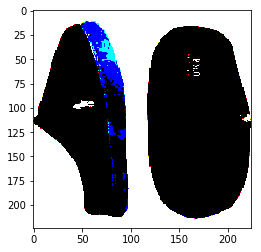

In [153]:
plt.imshow(input_img)

In [160]:
import json
import numpy as np

input_imgs = [input_img]
!rm -r image.json
with open("image.json", "w") as f:
  for image in input_imgs:
    print(1)
#     image = np.ones((224, 224, 3))
    # the format for ML Engine online predictions is: one JSON object per line
    data = json.dumps({"input_1": image.tolist()})  # "serving_input" because the ServingInput layer was named "serving". Keras appends "_input"
    f.write(data+'\n')

1


In [150]:
sys.getsizeof(input_img.tolist())

1856

In [151]:
!gsutil cp image.json gs://project-sample

Copying file://image.json [Content-Type=application/json]...
-
Operation completed over 1 objects/3.0 MiB.                                      


In [159]:
!gsutil cat gs://project-sample/preds/prediction.errors_stats-00000-of-00001

(u"Expected tensor name: input_1, got tensor name: [u'input_3'].", 1)


In [161]:
%%bash
INPUT=gs://project-sample/image.json
OUTPUT=gs://project-sample/preds
gsutil -m rm -rf $OUTPUT 
gcloud ml-engine jobs submit prediction image_pred_job_$(date -u +%y%m%d_%H%M%S) \
  --data-format=TEXT --region us-central1\
  --input-paths=$INPUT \
  --output-path=$OUTPUT \
  --model=fashion --version=v2

jobId: image_pred_job_190405_181815
state: QUEUED


Removing gs://project-sample/preds/prediction.errors_stats-00000-of-00001#1554487834865109...
Removing gs://project-sample/preds/prediction.results-00000-of-00001#1554487816148076...
/ [2/2 objects] 100% Done                                                       
Operation completed over 2 objects.                                              
Job [image_pred_job_190405_181815] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe image_pred_job_190405_181815

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs image_pred_job_190405_181815


In [70]:
# import requests
# import tensorflow as tf
# from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50

# def preprocess(image):
#     res = requests.get(image)
#     image_bytes = res.content
    
#     # Decode the image, end up with pixel values that are in the -1, 1 range
#     image = tf.image.decode_jpeg(contents = image_bytes, channels=3)
#     image = tf.expand_dims(input = image, axis = 0) # resize_bilinear needs batches
#     image = preprocess_resnet50(image)
#     return image
# img_test = np.array(preprocess('https://storage.cloud.google.com/project-sample/dataset1/100339229.jpeg'))

In [146]:
import sys
sys.getsizeof(input_img.tolist())
# input_img.shape

1856

In [137]:
result = !gcloud ml-engine predict --model=fashion \
    --json-instances image.json \
    --project=qwiklabs-gcp-3f19cbba7aa3ae63\
    --version v2
result

['ERROR: (gcloud.ml-engine.predict) HTTP request failed. Response: {',
 '  "error": {',
 '    "code": 400,',
 '    "message": "Request payload size exceeds the limit: 1572864 bytes.",',
 '    "status": "INVALID_ARGUMENT"',
 '  }',
 '}',
 '']

In [124]:
result

['ERROR: (gcloud.ml-engine.predict) HTTP request failed. Response: {',
 '  "error": {',
 '    "code": 400,',
 '    "message": "Request payload size exceeds the limit: 1572864 bytes.",',
 '    "status": "INVALID_ARGUMENT"',
 '  }',
 '}',
 '']

In [121]:
import pandas as pd
probabilities = np.stack([json.loads(p) for p in result[1:]]) # first line is the name of the input layer: drop it, parse the rest
# predictions = np.argmax(probabilities, axis=1)
res = pd.DataFrame(probabilities).T
res.columns=['prob']
res['label_ix'] = res.index.copy()
res.index = res.index.map(lambda x: CLASSES[x])
res.sort_values('prob')\
    .tail()\
    .prob\
    .plot(kind='barh')

JSONDecodeError: Extra data: line 1 column 10 (char 9)

In [18]:
%%bash
OUTDIR='test'

# export PYTHONPATH=${PYTHONPATH}:${PWD}/foo 
python3 -m image_model.task \
    --output_dir=$OUTDIR \
    --train_steps=1000 \
    --learning_rate=0.01 \
    --batch_size=40 \
    --batch_norm \
    --pretrained='res_50' \
    --train_data_path='gs://project-sample/dataset1_data_train.csv' \
    --eval_data_path='gs://project-sample/dataset1_data_eval.csv'

python3 -m image_model.task --output_dir=test --train_steps=1000 --learning_rate=0.01 --batch_size=40 --batch_norm --pretrained=res_50 --train_data_path=gs://project-sample/dataset1_data_train.csv --eval_data_path=gs://project-sample/dataset1_data_eval.csv


In [210]:
%%bash
OUTDIR=gs://${BUCKET}/image_model_$(date -u +%y%m%d_%H%M%S)/trained
JOBNAME=image_with_estimator_2_${MODEL_TYPE}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
    --region=$REGION \
    --module-name=image_model.task \
    --package-path=${PWD}/image_model \
    --job-dir=$OUTDIR \
    --staging-bucket=gs://$BUCKET \
    --scale-tier=CUSTOM \
    --runtime-version=$TFVERSION \
    --config=${PWD}/config.yml \
    -- \
    --output_dir=$OUTDIR \
    --train_steps=1000 \
    --learning_rate=0.01 \
    --batch_size=40 \
    --batch_norm \
    --pretrained='res_50' \
    --train_data_path='gs://project-sample/dataset1_data_train.csv' \
    --eval_data_path='gs://project-sample/dataset1_data_eval.csv'

gs://project-sample/image_model_190404_235750/trained us-central1 image_with_estimator_2__190404_235750
jobId: image_with_estimator_2__190404_235750
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [image_with_estimator_2__190404_235750] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe image_with_estimator_2__190404_235750

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs image_with_estimator_2__190404_235750


In [16]:
import json
import numpy as np
with open("image.json", "w") as f:
  for e in range(1):
    image = np.ones((224, 224, 3))
    # the format for ML Engine online predictions is: one JSON object per line
    data = json.dumps({"input_1": image.tolist()})  # "serving_input" because the ServingInput layer was named "serving". Keras appends "_input"
    f.write(data+'\n')

In [18]:
predictions = !gcloud ml-engine predict --model=fashion \
    --json-instances image.json \
    --project=qwiklabs-gcp-3f19cbba7aa3ae63\
    --version v1

In [19]:
predictions

['DENSE_1',
 '[0.0012311566388234496, 0.00344829517416656, 0.0013252045027911663, 0.003027876140549779, 0.02579280361533165, 0.0035687608178704977, 0.006811907980591059, 0.009789424017071724, 0.003974616527557373, 0.023292094469070435, 0.010436145588755608, 0.017773518338799477, 0.006583876442164183, 0.012856835499405861, 0.03823508322238922, 0.014570713974535465, 0.11357303708791733, 0.00017735411529429257, 0.002521135611459613, 0.017379138618707657, 0.004073919262737036, 0.02443917654454708, 0.0069253770634531975, 0.012676350772380829, 0.00843924842774868, 0.007023888174444437, 0.14175163209438324, 0.013692551292479038, 0.0067416769452393055, 0.011422364972531796, 0.0014128978364169598, 0.01152584794908762, 0.056582897901535034, 0.0007435620063915849, 0.01662624441087246, 0.03701480105519295, 0.004641812294721603, 0.016502875834703445, 0.006171627901494503, 0.009906752966344357, 0.0012863451847806573, 0.0048844823613762856, 0.00203006062656641, 0.0740479826927185, 0.0736600011587143,

In [115]:
max_prediction = -float("inf")
for i in range(len(predictions)):
      if predictions[i] > max_prediction:
          max_prediction = predictions[i]
          prediction_class = CLASSES_LIST[i]
print(prediction_class)

Bras


In [20]:
x = {}

In [21]:
print(x['something'])

KeyError: 'something'